https://gist.github.com/ocefpaf/3e365bdcc947161e9d45ba27146e964b

In [1]:
import pandas as pd


points = [
    (-(11 + 21.66 / 60), -(34 + 28.60 / 60)),
    (-(15 + 03.94 / 60), -(36 + 02.96 / 60)),
    (-(19 + 05.91 / 60), -(37 + 32.86 / 60)),
    (-(22 + 40.12 / 60), -(39 + 42.58 / 60)),
]

df = pd.DataFrame(points, columns=['lat', 'lon'])
df

lat        lon
0 -11.361000 -34.476667
1 -15.065667 -36.049333
2 -19.098500 -37.547667
3 -22.668667 -39.709667

In [2]:
dx = 4
dy = 3

extent = [
    df['lon'].min()-dx,
    df['lon'].max()+dx,
    df['lat'].min()-dy,
    df['lat'].max()+dy,
]

In [3]:
import numpy as np
from shapely.ops import linemerge, cascaded_union
from shapely.geometry import MultiPolygon, MultiLineString

def filter_feature(cfeature, extent):
    return list(cfeature.intersecting_geometries(extent))


def knn_search(x, D, K):
    """Find `K` nearest `x` neighbours on `D`."""
    m, n = D.shape
    x = np.atleast_2d(x)
    K = K if K < n else n
    # Euclidean distances from the other points.
    sqd = np.sqrt(((D - x[:n, :])**2).sum(axis=1))
    idx = np.argsort(sqd)
    return idx[K]

In [4]:
import cartopy.feature as cfeature

feature = cfeature.GSHHSFeature(scale='full')

In [5]:
geoms = filter_feature(feature, extent=extent)
geom = cascaded_union(geoms).boundary
line = linemerge(geom)[0]
coastline = np.array(line.coords)
line

In [6]:
points = list(zip(df.index.values, df['lon'].values, df['lat'].values))

idx = [knn_search([lon, lat], coastline, 1) for idx, lon, lat in points]

In [7]:
df['lonc'] = coastline[idx][:, 0]
df['latc'] = coastline[idx][:, 1]

In [8]:
import iris

iris.FUTURE.netcdf_promote=True

coord_values = {
    'longitude':lambda cell: int(extent[0])-1 <= cell <= int(extent[1])+1,
    'latitude': lambda cell: int(extent[2])-1 <= cell <= int(extent[3])+1
}

constraint = iris.Constraint(coord_values=coord_values)

url = 'http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/ETOPO1_Bed_g_gmt4.nc'

cube = iris.load_cube(url, constraint=constraint)

print(cube)

z / (1)                             (latitude: 1140; longitude: 901)
     Dimension coordinates:
          latitude                           x                -
          longitude                          -                x
     Attributes:
          Conventions: COARDS/CF-1.0
          GMT_version: 4.4.0
          actual_range: [-10898.   8271.]
          node_offset: 0
          title: ETOPO1_Bed_g_gmt4.grd


In [9]:
from palettable import colorbrewer

land = colorbrewer.get_map('Greens', 'sequential', 9)
ocean = colorbrewer.get_map('Blues', 'sequential', 7, reverse=True)
colors = np.array(ocean.mpl_colors + land.mpl_colors[2:])

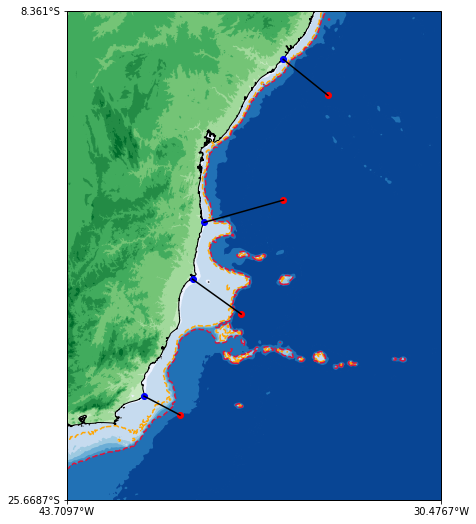

In [10]:
%matplotlib inline

import iris.plot as iplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig, ax = plt.subplots(figsize=(9, 9),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)

levels = [-4000, -2500, -1000, -700, -400, -145, -10, 0, 10, 145, 400, 800, 1200, 1600]
iplt.contourf(cube, levels, colors=colors, extend='both')
iplt.contour(cube, [-100], colors='orange', extend='both', linestyle='solid')
iplt.contour(cube, [-1000], colors='crimson', extend='both', linestyle='solid')

ax.add_feature(feature)
ax.set_extent(extent)

ax.plot(df['lon'], df['lat'], 'ro')
ax.plot(df['lonc'], df['latc'], 'bo')

for segment in zip(df[['lon', 'lonc']].values, df[['lat', 'latc']].values):
    ax.plot(*segment, color='k')

ax.set_xticks([extent[0], extent[1]], crs=ccrs.PlateCarree())
ax.set_yticks([extent[2], extent[3]], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

In [11]:
import seawater as sw

km = []
nm = []
for k, v in df.iterrows():
    nm.append(
        sw.dist([v['lon'], v['lonc']],
                [v['lat'], v['latc']],
                units='nm')[0].squeeze()
    )
    km.append(
        sw.dist([v['lon'], v['lonc']],
                [v['lat'], v['latc']],
                units='km')[0].squeeze()
    )

df['dist km'] = km
df['dist nm'] = nm
df

lat        lon       lonc       latc             dist km  \
0 -11.361000 -34.476667 -36.057528 -10.087083    210.277092503741   
1 -15.065667 -36.049333 -38.859194 -15.856278   319.9256822976671   
2 -19.098500 -37.547667 -39.265417 -17.865861  218.98464354748728   
3 -22.668667 -39.709667 -40.983778 -22.000861  152.45736270292898   

              dist nm  
0  113.54054670828347  
1  172.74604875683968  
2  118.24224813579227  
3   82.32039022836338